# Verlet Algorithm

In molecular dynamics, the most commonly used time integration algorithm is probably the so-called Verlet algorithm [L. Verlet, Computer experiments on classical fluids. I. Thermodynamical properties of Lennard-Jones molecules, Physical Review 159, 98 (1967)]. The basic idea is to write two third-order Taylor expansions for the positions ${\bf r} (t)$, one forward and one backward in time. Calling $\bf v$ the velocities, $\bf a$ the accelerations, and $\bf b$ the third derivatives of ${\bf r}$ with respect to $t$, one has:
$$\begin{equation}
{\bf r} (t+\Delta t) = {\bf r} (t) + {\bf v} (t) \Delta t + \frac{1}{2} {\bf a}(t) \Delta t^2 + (1/6) {\bf b} (t) \Delta t^3
 + O(\Delta t^4) \end{equation}
$$
$$
\begin{equation}
{\bf r} (t-\Delta t) = {\bf r} (t) - {\bf v} (t) \Delta t + \frac{1}{2} {\bf a}(t) \Delta t^2 - (1/6) {\bf b} (t) \Delta t^3
 + O(\Delta t^4) \end{equation}
$$
Adding the two expressions gives
$$\begin{equation}
{\bf r} (t+\Delta t) = 2{\bf r} (t) - {\bf r} (t-\Delta t)
 + {\bf a} (t) \Delta t^2 + O(\Delta t^4) \end{equation}	
$$
This is the basic form of the Verlet algorithm. Since we are integrating Newton's equations, ${\bf a} (t)$ is just the force divided by the mass, and the force is in turn a function of the positions ${\bf r} (t)$:
$$\begin{equation}
{\bf a} (t) = - \frac{1}{m} {\bf\nabla} V\left( {\bf r}(t) \right) \end{equation}	
$$
As one can immediately see, the truncation error of the algorithm when evolving the system by $\Delta t$ is of the order of  $\Delta t^4$, even if third derivatives do not appear explicitly. This algorithm is at the same time simple to implement, accurate and stable, explaining its large popularity among molecular dynamics simulators.

While the velocities are not needed for the time evolution, their knowledge is sometimes necessary. Moreover, they are required to compute the kinetic energy $K$, whose evaluation is necessary to test the conservation of the total energy $E=K+V$. This is one of the most important tests to verify that a MD simulation is proceeding correctly. One could compute the velocities from the positions by subtracting the previous expression to obtain:

$$\begin{equation}
{\bf v} (t) = \frac { {\bf r}(t+\Delta t) - {\bf r}(t-\Delta t) }
 { 2 \Delta t } . \end{equation}
$$
However, the error associated to this expression is of order $\Delta t^2$ rather than $\Delta t^4$.

The main problem with the Verlet algorithsm is that it is not self starting, and the first step needs to be computed by different means. An additional problem is that the new velocity is found by computing the difference between two quantities of the same order of magnitude. When using computers which always operate with finite numerical precision, such an operation results in a loss of numerical precision and may give rise to substantial roundoff error.

An even better implementation of the same basic algorithm is the so-called "**velocity Verlet scheme**", where positions, velocities and accelerations at time $t+\Delta t$ are obtained from the same quantities at time $t$ in the following way:

$$\begin{eqnarray}
{\bf r} (t + \Delta t) &=& {\bf r} (t) + {\bf v} (t) \Delta t + (1/2) {\bf a} (t) \Delta t^2 \\
{\bf v} (t + \Delta t/2) &=& {\bf v} (t) + (1/2) {\bf a} (t) \Delta t \\
{\bf a} (t + \Delta t) &=& - (1/m) {\bf\nabla} V \left( {\bf r}(t+\Delta t) \right) \\ 
{\bf v} (t + \Delta t) &=& {\bf v} (t + \Delta t/2) + (1/2) {\bf a} (t + \Delta t) \Delta t 
\end{eqnarray}$$

Note how we need $9N$ memory locations to save the $3N$ positions, velocities and accelerations, but we never need to have simultaneously stored the values at two different times for any one of these quantities.

Here, we modify the code for particle2 implementing velocity Verlet:

In [35]:
GM = 4*math.pi**2

class particle2(object):
    
    def __init__(self, mass=1., x=0., y=0., vx=0., vy=0., fx=0., fy=0., dt=.001):
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.dt = dt
        self.halfdt = self.dt / 2.
        self.fx = fx
        self.fy = fy     
    
    def accel(self):
        self.vx += self.fx * self.halfdt / self.mass
        self.vy += self.fy * self.halfdt / self.mass
        
    def move(self):
        self.x += self.vx * self.dt + self.fx * self.dt * self.halfdt / self.mass
        self.y += self.vy * self.dt + self.fy * self.dt * self.halfdt / self.mass
        
        
    def get_force(self):  # returns force per unit of mass (acceleration)
        r = math.sqrt(self.x*self.x+self.y*self.y)
        r3 = r * r * r
        self.fx = -GM * self.mass * self.x/r3
        self.fy = -GM * self.mass * self.y/r3
        #self.fx /= self.mass
        #self.fy /= self.mass
    
    def verlet2(self):
        self.move()
        self.accel()
        self.get_force()
        self.accel()
    
    def verlet(self, dt):
        self.get_force(fx, fy) # before I move to the new position
        self.x += self.vx*dt + 0.5*fx*dt*dt
        self.y += self.vy*dt + 0.5*fy*dt*dt
        self.vx += 0.5*fx*dt
        self.vy += 0.5*fy*dt
        self.get_force(fx, fy) # after I move to the new position
        self.vx += 0.5*fx*dt
        self.vy += 0.5*fy*dt



In [38]:
import math
import numpy as np


NPLANETS = 2

m1 = 0.1
r1 = 1.                  # radius of the orbit
v1 = math.sqrt(GM/r1)    # This is the condition for circular orbits 

m2 = 0.01
r2 = 4./3.               # radius of the orbit
v2 = math.sqrt(GM/r2)    # This is the condition for circular orbits 

dt = 0.001               # time step
tmax = 2.
nsteps = int(tmax/dt)

x = np.zeros(shape=(nsteps,NPLANETS))
y = np.zeros(shape=(nsteps,NPLANETS))
vx = np.zeros(shape=(nsteps,NPLANETS)) 
vy = np.zeros(shape=(nsteps,NPLANETS))
energy = np.zeros(shape=(nsteps,NPLANETS))

x[0,0] = r1
y[0,0] = 0.
vx[0,0] = 0.
vy[0,0] = v1
energy[0][0] = 0.5*v1**2 - GM/r1
x[0,1] = r2
y[0,1] = 0.
vx[0,1] = 0.
vy[0,1] = v2
energy[0][1] = 0.5*v2**2 - GM/r2

planets = []
for i in range(NPLANETS):        # create a list of NPLANETS particle2's
    planets.append([particle2])

m = [m1, m2]
for i in range(NPLANETS):
    planets[i] = particle2(m[i], x[0,i], y[0,i], vx[0,i], vy[0,i], 0, 0, dt)
    r = math.sqrt(planets[i].x*planets[i].x+planets[i].y*planets[i].y);
    r3 = r * r * r;
    fx = -GM*planets[i].mass*planets[i].x/r3;
    fy = -GM*planets[i].mass*planets[i].y/r3;
    planets[i].fx = fx
    planets[i].fy = fy

for i in range(1,nsteps):
    for n in range(0,NPLANETS):
        planets[n].verlet2()
        x[i,n] = planets[n].x
        y[i,n] = planets[n].y
        vx[i,n] = planets[n].vx
        vy[i,n] = planets[n].vy
        #energy[i,n] = 0.5*(planets[n].vx**2+planets[n].vy**2) - GM/r

t = np.linspace(0.,tmax,nsteps)    


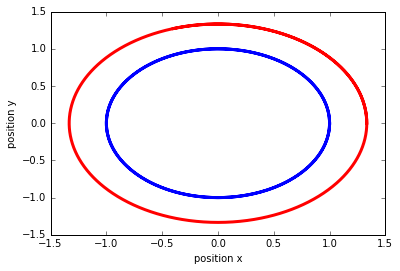

In [39]:
%matplotlib inline
from matplotlib import pyplot
pyplot.plot(x[:,0], y[:,0], color='blue', ls='-', lw=3)
pyplot.plot(x[:,1], y[:,1], color='red', ls='-', lw=3)

pyplot.xlabel('position x')
pyplot.ylabel('position y');

### Challenge 2.3:

Use velocity verlet to simulate the mini-solar system from Challenge 2.2.
Can you come up with a different way to write the algorithm such that you call get_force only once per move?